## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [156]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import time


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [135]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [136]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [137]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [72]:
len(fmnist_dataset_test)

10000

In [73]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [27]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(input_shape, 500, bias=False), 
            nn.BatchNorm1d(500),
            nn.ELU(),
            nn.Linear(500, 250, bias=False),
            nn.BatchNorm1d(250),
            nn.ELU(),
            nn.Linear(250, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [28]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,000
       BatchNorm1d-3                  [-1, 500]           1,000
               ELU-4                  [-1, 500]               0
            Linear-5                  [-1, 250]         125,000
       BatchNorm1d-6                  [-1, 250]             500
               ELU-7                  [-1, 250]               0
            Linear-8                   [-1, 10]           2,510
Total params: 521,010
Trainable params: 521,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.99
Estimated Total Size (MB): 2.01
----------------------------------------------------------------


Your experiments come here:

In [29]:
model = TinyNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3)

In [33]:
def train_model(model, train_loader, loss_fn, opt, n_epochs, lr_scheduler=None):
    for epoch in range(n_epochs):
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            preds = model.forward(X_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if lr_scheduler:
            lr_scheduler.step(loss)

        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')
        

In [34]:
train_model(model, train_loader, loss_func, opt, n_epochs=16, lr_scheduler=lr_scheduler)

Epoch 1 of 16 took 9.920s
Epoch 2 of 16 took 9.873s
Epoch 3 of 16 took 9.918s
Epoch 4 of 16 took 9.854s
Epoch 5 of 16 took 9.652s
Epoch 6 of 16 took 9.831s
Epoch 7 of 16 took 9.784s
Epoch 8 of 16 took 9.703s
Epoch 9 of 16 took 9.770s
Epoch 10 of 16 took 9.777s
Epoch 11 of 16 took 9.761s
Epoch 12 of 16 took 9.785s
Epoch 13 of 16 took 9.957s
Epoch 14 of 16 took 9.927s
Epoch 15 of 16 took 9.974s
Epoch 16 of 16 took 9.898s


TypeError: ignored

In [35]:
def test_model(model, test_loader):
    with torch.no_grad():
        model.eval()
        right_preds, total_preds = 0, 0
    
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            preds = model(inputs)
            right_preds += torch.sum(preds.argmax(dim=1) == targets).item()
            total_preds += targets.size()[0]
            
    return right_preds / total_preds

In [36]:
test_acc = test_model(model, test_loader)
print("Test accuracy =", test_acc)

Test accuracy = 0.8992


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [40]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 50000), 
            nn.LeakyReLU(), 
            nn.Linear(50000, 10)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [41]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                [-1, 50000]      39,250,000
         LeakyReLU-3                [-1, 50000]               0
            Linear-4                   [-1, 10]         500,010
Total params: 39,750,010
Trainable params: 39,750,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.77
Params size (MB): 151.63
Estimated Total Size (MB): 152.41
----------------------------------------------------------------


In [63]:
model = OverfittingNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3)

In [47]:
def train_val_model(model, train_loader, val_loader, loss_fn, opt, n_epochs, 
                                                            lr_scheduler=None):
    train_loss, train_accuracy = [], []
    val_loss, val_accuracy = [], []
    
    for epoch in range(n_epochs):
        ep_train_loss, ep_train_accuracy = [], []
        ep_val_loss, ep_val_accuracy = [], []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            preds = model.forward(X_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

            y_pred = preds.argmax(dim=1)
            acc = torch.sum(y_pred == y_batch).item() / y_batch.size()[0]

            ep_train_accuracy.append(acc)
            ep_train_loss.append(loss.item())

        if lr_scheduler:
            lr_scheduler.step(loss)

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                # compute predictions
                preds = model.forward(X_batch)
                loss = loss_fn(preds, y_batch)
                ep_val_loss.append(loss.item())

                y_pred = preds.argmax(dim=1)
                acc = torch.sum(y_pred == y_batch).item() / y_batch.size()[0]
                ep_val_accuracy.append(acc)

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')
        train_loss.append(np.mean(ep_train_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

    return train_loss, train_accuracy, val_loss, val_accuracy

In [64]:
train_loss, train_acc, val_loss, val_acc = train_val_model(model, 
                                                      train_loader, 
                                                      test_loader, 
                                                      loss_func, 
                                                      opt, 
                                                      n_epochs=12, 
                                                      lr_scheduler=lr_scheduler)

Epoch 1 of 12 took 21.154s
Epoch 2 of 12 took 21.072s
Epoch 3 of 12 took 21.013s
Epoch 4 of 12 took 21.150s
Epoch 5 of 12 took 21.027s
Epoch 6 of 12 took 21.067s
Epoch 7 of 12 took 21.116s
Epoch 8 of 12 took 21.193s
Epoch 9 of 12 took 21.176s
Epoch 10 of 12 took 21.125s
Epoch 11 of 12 took 21.194s
Epoch 12 of 12 took 21.201s


In [128]:
colors = ('olivedrab', 'magenta')

def plot_training_results(train_data, val_data, ylabel="Loss value"):
    plt.figure(figsize=(12, 7))
    plt.plot(train_data, color=colors[0], label="Train")
    plt.plot(val_data, color=colors[1], label="Test")

    plt.title(f"{ylabel} during train/test")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend(fontsize=14)
    plt.show()

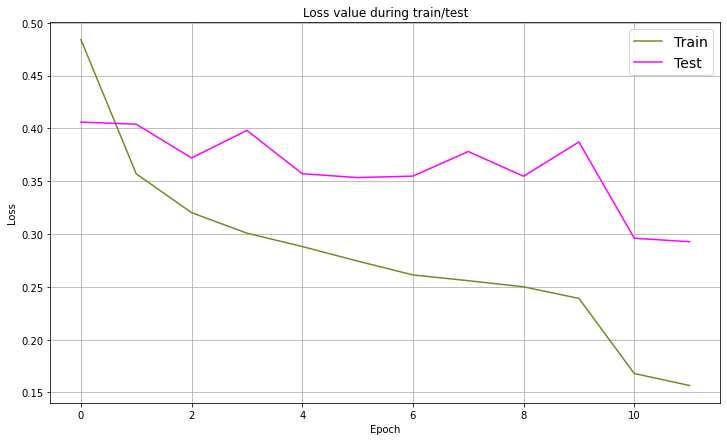

In [66]:
# Loss graphic
plot_training_results(train_loss, val_loss)

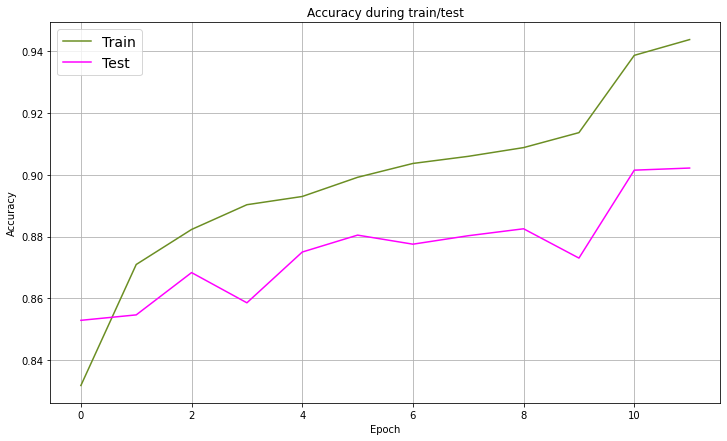

In [67]:
# Accuracy graphic
plot_training_results(train_acc, val_acc, ylabel="Accuracy")

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

**1) Добавление DropOut-а**

In [57]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(input_shape, 50000), 
            nn.Dropout(p=0.7),
            nn.LeakyReLU(), 
            nn.Linear(50000, 10)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [54]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                [-1, 50000]      39,250,000
           Dropout-3                [-1, 50000]               0
         LeakyReLU-4                [-1, 50000]               0
            Linear-5                   [-1, 10]         500,010
Total params: 39,750,010
Trainable params: 39,750,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.15
Params size (MB): 151.63
Estimated Total Size (MB): 152.79
----------------------------------------------------------------


In [58]:
model = FixedNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3)

In [59]:
train_loss, train_acc, val_loss, val_acc = train_val_model(model, 
                                                      train_loader, 
                                                      test_loader, 
                                                      loss_func, 
                                                      opt, 
                                                      n_epochs=12, 
                                                      lr_scheduler=lr_scheduler)

Epoch 1 of 12 took 21.522s
Epoch 2 of 12 took 21.520s
Epoch 3 of 12 took 21.420s
Epoch 4 of 12 took 21.440s
Epoch 5 of 12 took 21.408s
Epoch 6 of 12 took 21.478s
Epoch 7 of 12 took 21.497s
Epoch 8 of 12 took 21.460s
Epoch 9 of 12 took 21.451s
Epoch 10 of 12 took 21.526s
Epoch 11 of 12 took 21.387s
Epoch 12 of 12 took 21.409s


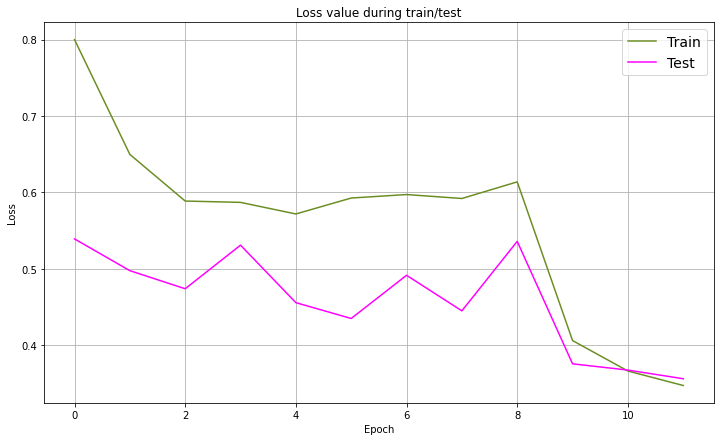

In [60]:
# Loss graphic
plot_training_results(train_loss, val_loss)

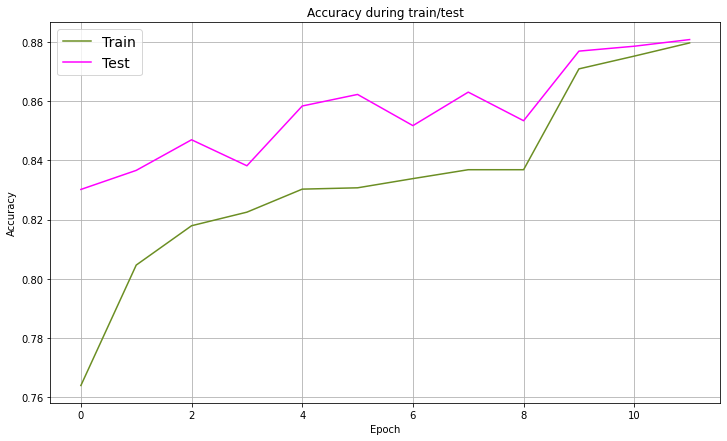

In [61]:
# Accuracy graphic
plot_training_results(train_acc, val_acc, ylabel="Accuracy")

**2) Batchnorm**

In [134]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(input_shape, 50000), 
            nn.BatchNorm1d(50000),
            nn.LeakyReLU(), 
            nn.Linear(50000, 10)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [138]:
model = FixedNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=4)

In [139]:
train_loss, train_acc, val_loss, val_acc = train_val_model(model, 
                                                      train_loader, 
                                                      test_loader, 
                                                      loss_func, 
                                                      opt, 
                                                      n_epochs=12, 
                                                      lr_scheduler=lr_scheduler)

Epoch 1 of 12 took 22.217s
Epoch 2 of 12 took 22.230s
Epoch 3 of 12 took 22.186s
Epoch 4 of 12 took 22.228s
Epoch 5 of 12 took 22.251s
Epoch 6 of 12 took 22.212s
Epoch 7 of 12 took 22.236s
Epoch 8 of 12 took 22.076s
Epoch 9 of 12 took 22.122s
Epoch 10 of 12 took 22.140s
Epoch 11 of 12 took 22.161s
Epoch 12 of 12 took 22.111s


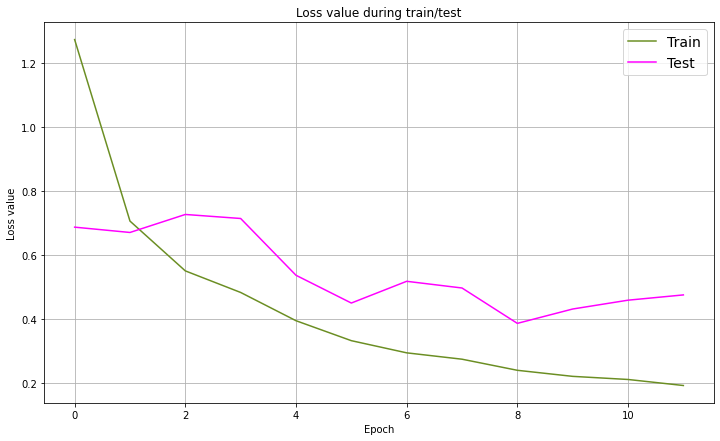

In [140]:
# Loss graphic
plot_training_results(train_loss, val_loss)

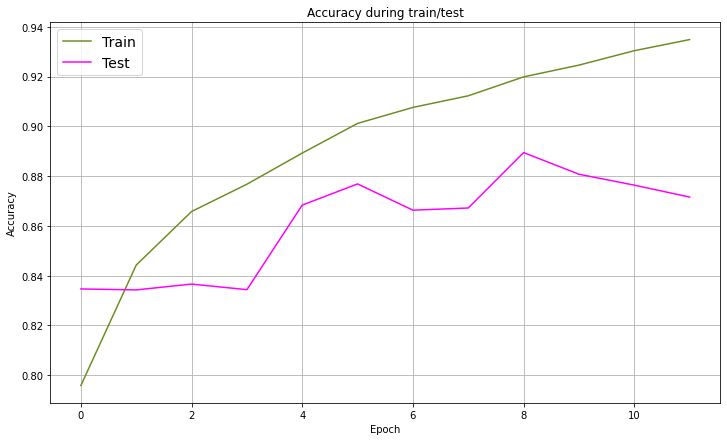

In [141]:
# Accuracy graphic
plot_training_results(train_acc, val_acc, ylabel="Accuracy")

**3) Ранняя остановка + добавление шума к данным**  

<i>Мотивация<i>: Эвристически мы могли бы ожидать, что шум "размажет" каждый объект из обучающей выборки и затруднит точное соответствие сети отдельным изображениям, а следовательно, уменьшит чрезмерную подгонку под обучающие данные

In [169]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + \
                '(mean={0}, std={1})'.format(self.mean, self.std)

In [170]:
download = True
train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.445], [0.269]),
        AddGaussianNoise(0.0, 0.2)
])
test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.445], [0.269]),
])

fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [171]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [172]:
def plot_from_batch_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    for i in range(grid_size[0] * grid_size[1]):
        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = data_batch[i].numpy()[0, :, :]
        
        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(0.269 * batch_image_ndarray + 0.445, 0, 1)
        
        # display batch samples with labels
        sample_title = 'Label = %d' % (label_batch[i])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    pass

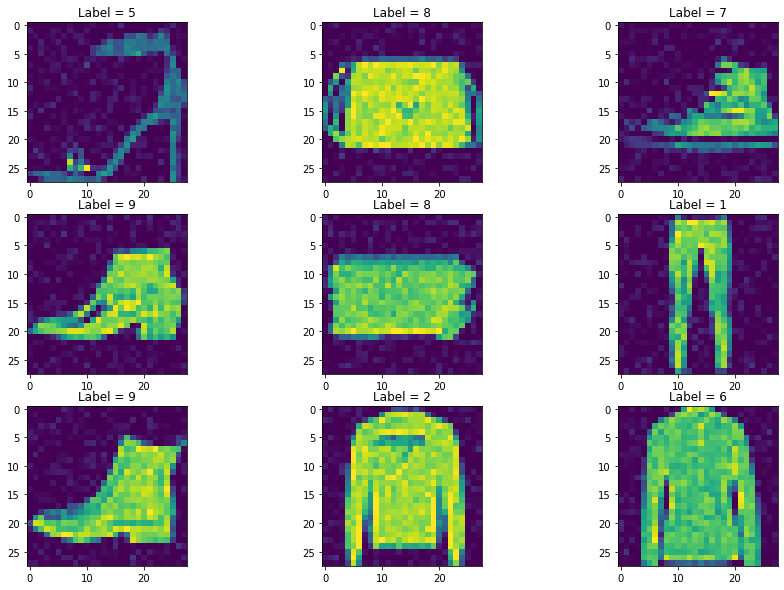

In [173]:
plot_from_batch_generator(train_loader)

In [164]:
def train_with_early_stop(model, train_loader, val_loader, loss_fn, opt, 
                          n_epochs, lr_scheduler=None, max_patience=np.inf):
    train_loss, train_accuracy = [], []
    val_loss, val_accuracy = [], []

    best_loss, patience = np.inf, 0
    
    for epoch in range(n_epochs):
        ep_train_loss, ep_train_accuracy = [], []
        ep_val_loss, ep_val_accuracy = [], []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            preds = model.forward(X_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

            y_pred = preds.argmax(dim=1)
            acc = torch.sum(y_pred == y_batch).item() / y_batch.size()[0]

            ep_train_accuracy.append(acc)
            ep_train_loss.append(loss.item())

        if lr_scheduler:
            lr_scheduler.step(loss)

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                # compute predictions
                preds = model.forward(X_batch)
                loss = loss_fn(preds, y_batch)
                ep_val_loss.append(loss.item())

                y_pred = preds.argmax(dim=1)
                acc = torch.sum(y_pred == y_batch).item() / y_batch.size()[0]
                ep_val_accuracy.append(acc)

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')
        train_loss.append(np.mean(ep_train_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        if val_loss[-1] < best_loss:
            best_loss = val_loss[-1]
            patience = 0
        else:
            patience += 1

        if patience >= max_patience:
            print("Max patience was reached")
            break

    return train_loss, train_accuracy, val_loss, val_accuracy

In [174]:
model = OverfittingNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=4)

In [175]:
train_loss, train_acc, val_loss, val_acc = train_with_early_stop(model, 
                                                      train_loader, 
                                                      test_loader, 
                                                      loss_func, 
                                                      opt, 
                                                      n_epochs=16, 
                                                      lr_scheduler=lr_scheduler, 
                                                      max_patience=4)

Epoch 1 of 16 took 24.993s
Epoch 2 of 16 took 24.795s
Epoch 3 of 16 took 24.784s
Epoch 4 of 16 took 24.877s
Epoch 5 of 16 took 24.847s
Epoch 6 of 16 took 24.944s
Epoch 7 of 16 took 24.898s
Epoch 8 of 16 took 24.684s
Max patience was reached


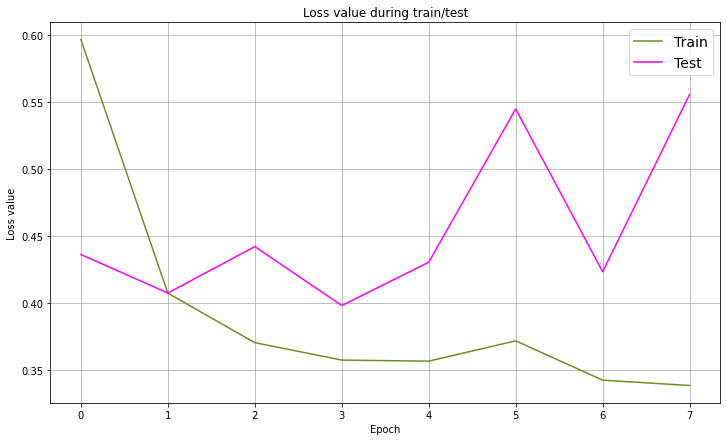

In [176]:
# Loss graphic
plot_training_results(train_loss, val_loss)

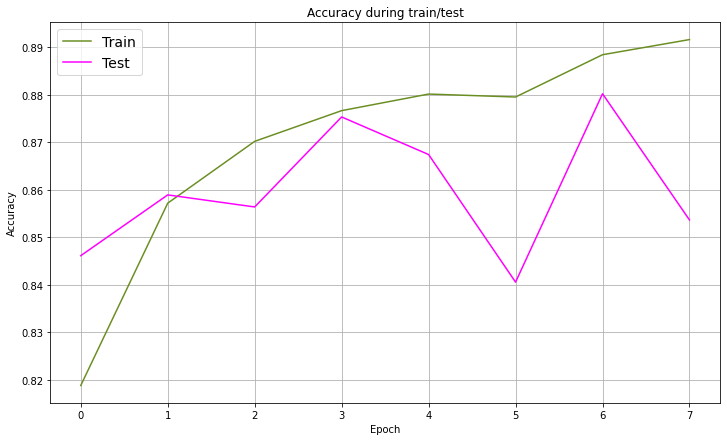

In [177]:
# Accuracy graphic
plot_training_results(train_acc, val_acc, "Accuracy")

**4) Добавление шума к данным** 

In [165]:
model = OverfittingNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=4)

In [166]:
train_loss, train_acc, val_loss, val_acc = train_val_model(model, 
                                                      train_loader, 
                                                      test_loader, 
                                                      loss_func, 
                                                      opt, 
                                                      n_epochs=16, 
                                                      lr_scheduler=lr_scheduler)

Epoch 1 of 16 took 24.965s
Epoch 2 of 16 took 24.994s
Epoch 3 of 16 took 24.679s
Epoch 4 of 16 took 24.680s
Epoch 5 of 16 took 24.650s
Epoch 6 of 16 took 24.806s
Epoch 7 of 16 took 24.725s
Epoch 8 of 16 took 24.712s
Epoch 9 of 16 took 24.782s
Epoch 10 of 16 took 24.662s
Epoch 11 of 16 took 24.749s
Epoch 12 of 16 took 24.866s
Epoch 13 of 16 took 24.779s
Epoch 14 of 16 took 24.688s
Epoch 15 of 16 took 24.713s
Epoch 16 of 16 took 24.934s


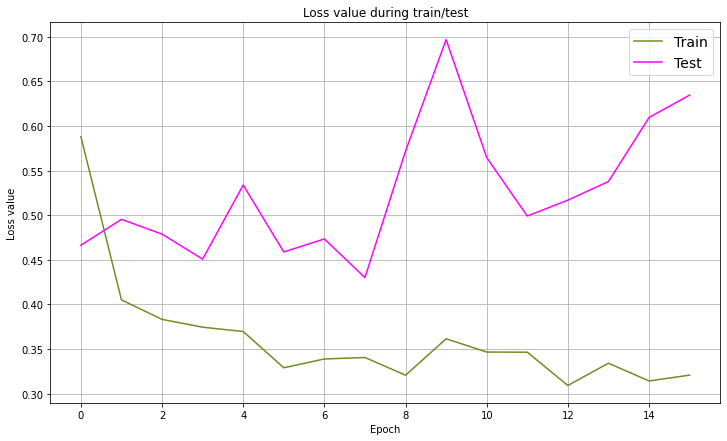

In [167]:
# Loss graphic
plot_training_results(train_loss, val_loss)

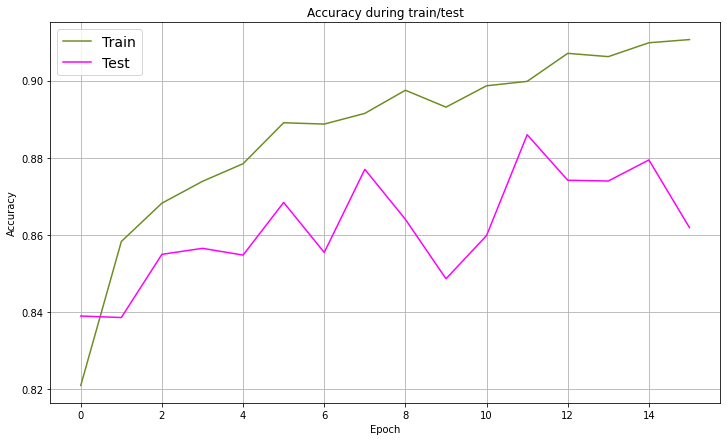

In [168]:
# Accuracy graphic
plot_training_results(train_acc, val_acc, "Accuracy")

### Conclusions:
Было применено несколько подходов для борьбы с переобучением: добавление в модель `BatchNormalisation` и `DropOut`, зашумление данных и ранняя остановка. 

1) Dropout сильно уменьшил эффект переобучения за счёт того, что  часть нейронов была "отключена" при обучении модели и благодаря этому модель не стала подстраиваться под значения определённых признаков  

2) BatchNormalization же не смог решить проблему переобучения для нашей модели, поскольку его эффект регуляризации устроен по-другому: данный слой уменьшает internal covariate shift (изменение распределения параметров сети, возникающее в процессе обучения) и стабилизирует распределение параметров сети (а именно среднее и дисперсию)  

3) Добавление шума к данным также не повлияло на переобучение модели. Возможно, были неудачно подобраны гиперпараметры шума, и стоит с ними нужно дополнительно поиграться  

4) Ранняя остановка показала свою эффективность в борьбе с переобучением